In [4]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [5]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [6]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [5]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/greedy")

In [ ]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/random")

In [ ]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/landscape_maximizes")

In [ ]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/mimic")

In [7]:
newdata1 = dict(h5py.File("../data/random/random.hdf5"))
newdata2 = dict(h5py.File("../data/greedy/greedy.hdf5"))
newdata3 = dict(h5py.File("../data/mimic/mimic.hdf5"))
newdata4 = dict(h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5"))

In [8]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [9]:
def means_stds_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_list = []
    for step_index in range(steps):
        stds = np.std(pops_trial_index [step_index])
        means = np.mean(pops_trial_index[step_index])
        mean_stds_list.append([means, stds])
    return mean_stds_list

def means_stds_mode_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_mode_list = []
    for step_index in range(steps):
        total = sum(pops_trial_index[step_index])
        stds = np.std(pops_trial_index[step_index])
        means = np.mean(pops_trial_index[step_index])
        mode = max(pops_trial_index[step_index])
        mean_stds_mode_list.append([total,stds,means,mode])
    return mean_stds_mode_list

def extract_total(list_of_lists):
    return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    return [sublist[2] for sublist in list_of_lists]
def extract_mode(list_of_lists):
    return [sublist[3] for sublist in list_of_lists]

In [10]:
def moving_average(data, window_size=10):
    """
    Function to calculate the moving average of a given data array.
    
    Parameters:
    - data: The input data array.
    - window_size: The size of the moving average window.
    
    Returns:
    - moving_avg: The moving average array.
    """
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

def plot_four_stats_as_function_of_time(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    plt.plot(time_steps, list1, color='blue', label='Random')
    plt.plot(time_steps, list2,color='orange', label='Greedy')
    plt.plot(time_steps, list3, color='red',label='Mimic')
    plt.plot(time_steps, list4, color='green',label='Landmax')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
    #plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

def plot_four_stats_as_function_of_time_avg(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    #plt.plot(time_steps, list1, color='blue', label='Random')
#    plt.plot(time_steps, list2,color='orange', label='Greedy')
    #plt.plot(time_steps, list3, color='green',label='Land_max')
    #plt.plot(time_steps, list4, color='red',label='Mimic')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
   # plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

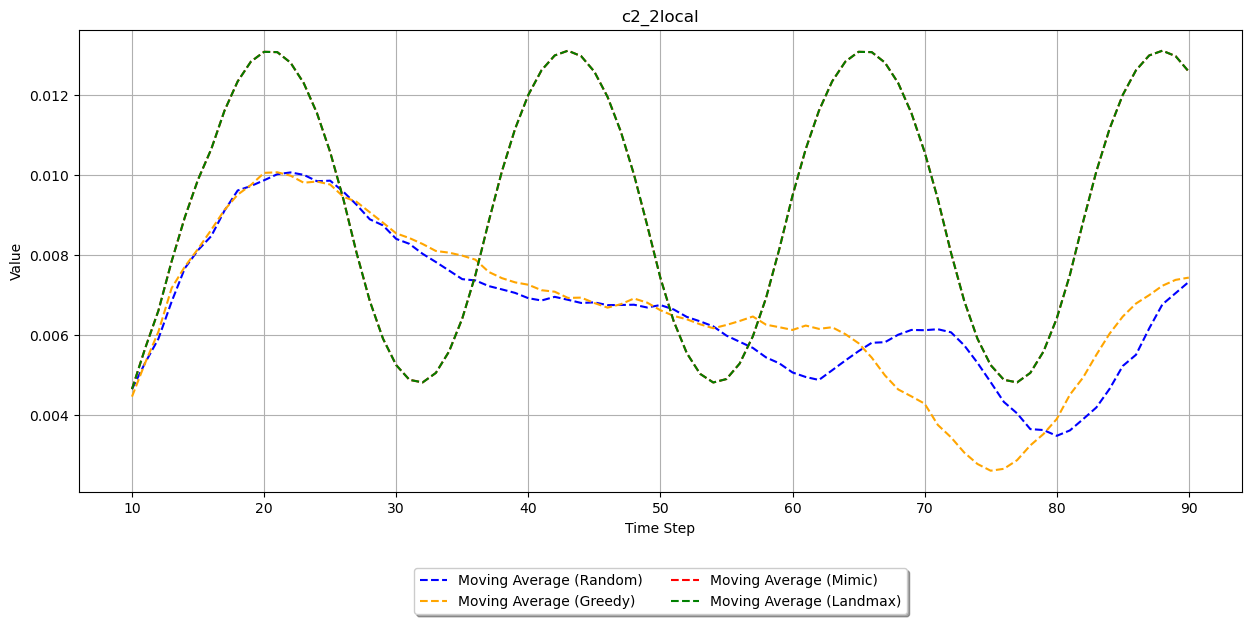

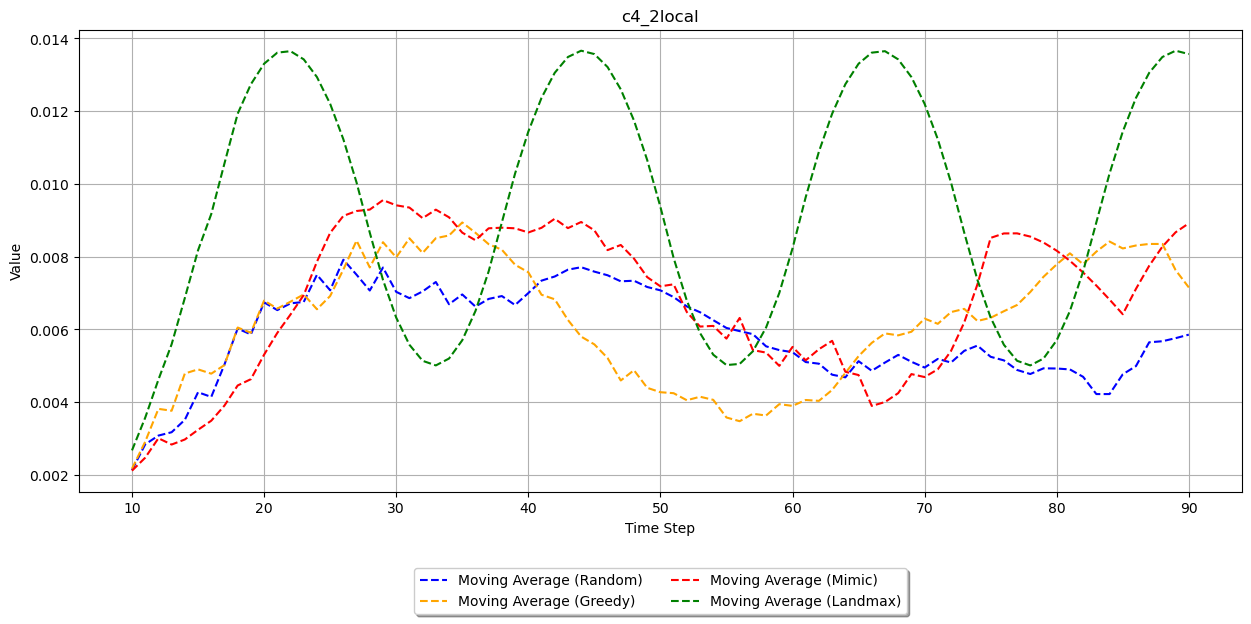

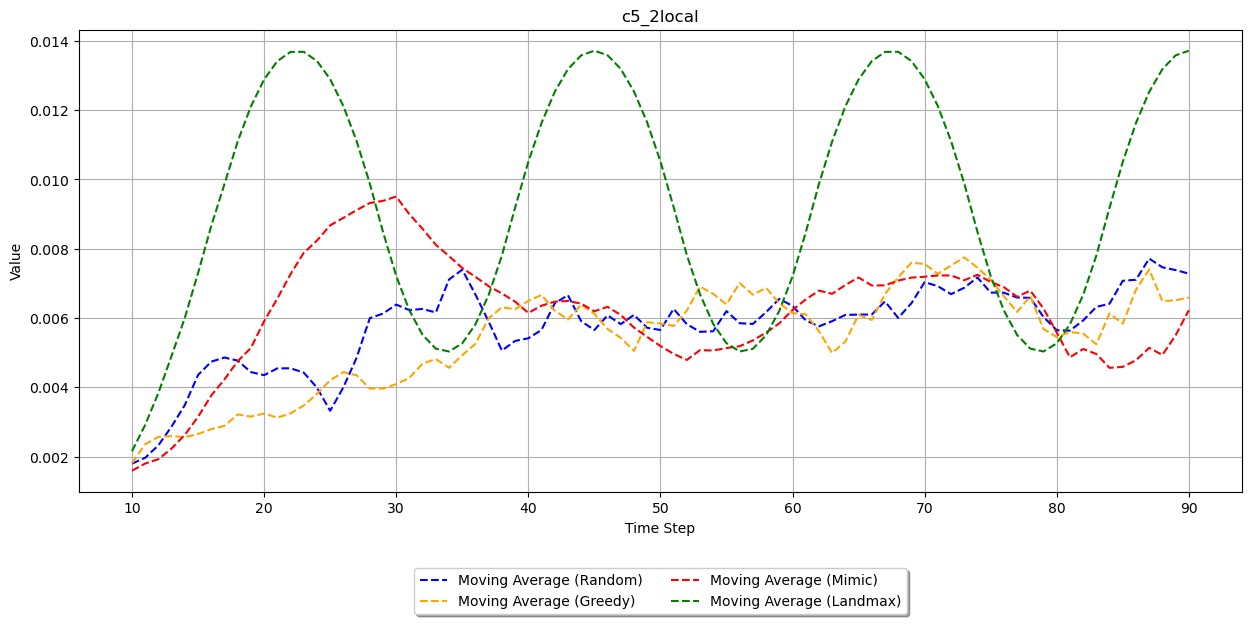

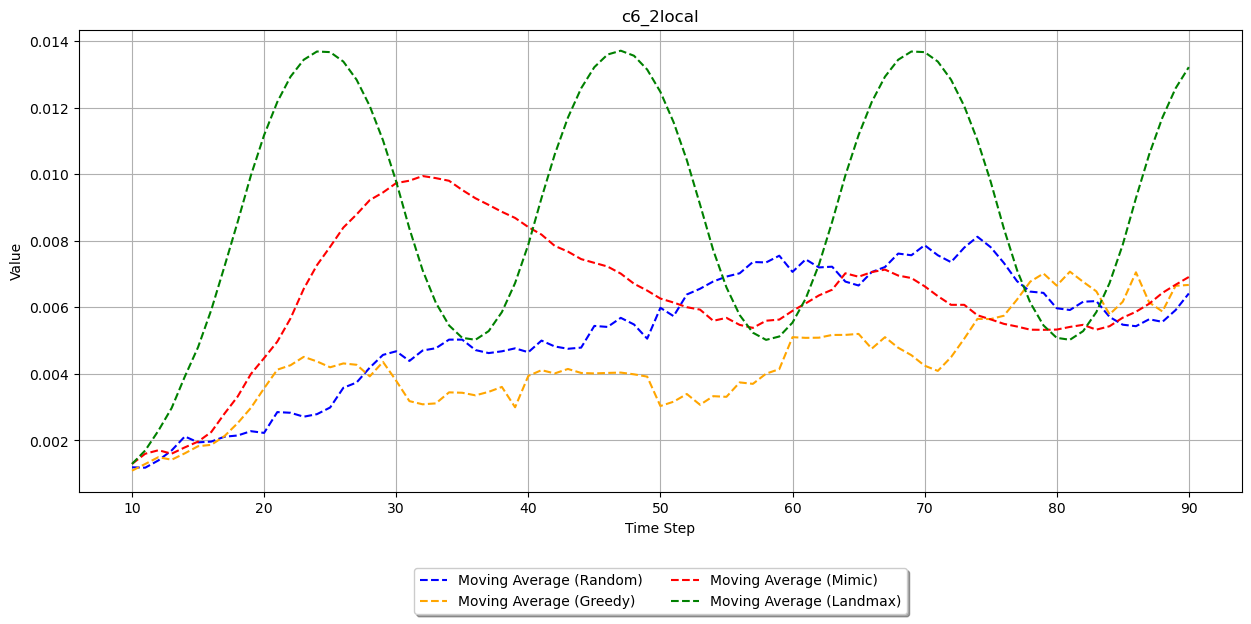

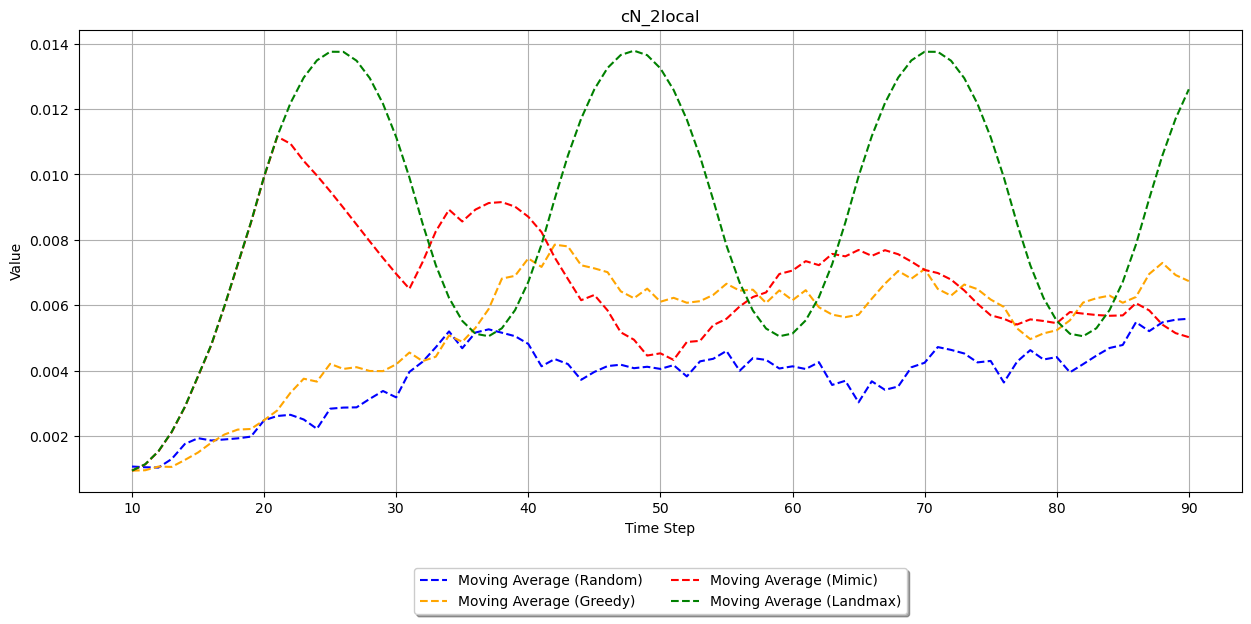

In [67]:
list_conn = ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
size=[8]
for size in sizes:
    for conn in list_conn:
        pops_random = get_pops(newdata1,size,conn,"random")
        pops_greedy = get_pops(newdata2,size,conn,"greedy")
        pops_mimic = get_pops(newdata3,size,conn,"mimic")
        pops_landmax = get_pops(newdata4,size,conn,"landscape_maximizes")
        
        stds_random=extract_stds(means_stds_of_pops_of_one_sim_index(tz_two_q_dyns_map(pops_random[0])))
        stds_greedy=extract_stds(means_stds_of_pops_of_one_sim_index(tz_two_q_dyns_map(pops_greedy[0])))
        stds_mimic=extract_stds(means_stds_of_pops_of_one_sim_index(tz_two_q_dyns_map(pops_mimic[0])))
        stds_landmax=extract_stds(means_stds_of_pops_of_one_sim_index(tz_two_q_dyns_map(pops_landmax[0])))
        
        plot_four_stats_as_function_of_time_avg(stds_random,stds_greedy, stds_mimic,stds_landmax,filename = 'tz_stds_random_greedy_landmax_temp_homo',title = conn)


In [11]:
#MI of every pair
def mutual_info_dicts(twoQdms, trial_index):
    mutual_info_list = []
    for time_step in twoQdms[trial_index]:
        mutual_info_dict = {}
        mutual_info = measure.mutual_information_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_mutual_info = {k: v if v >= 1e-6 else 0 for k, v in mutual_info.items()}
        # Update the mutual_info_dict with the filtered mutual info for the current time step
        mutual_info_dict.update(filtered_mutual_info)
        # Append the mutual_info_dict to the list
        mutual_info_list.append(mutual_info_dict)
    return mutual_info_list

In [ ]:
#Analysis begins: 

In [ ]:
#For a given size, do all connectivity

In [12]:
twoQdmsrandomc2 = get_2_qbit_dms(newdata1,8,"c2_2local","random")
twoQdmsgreedyc2 = get_2_qbit_dms(newdata2,8,"c2_2local","greedy")
twoQdmsmimicc2 = get_2_qbit_dms(newdata3,8,"c2_2local","mimic")
twoQdmslandscape_maxc2 = get_2_qbit_dms(newdata4,8,"c2_2local","landscape_maximizes")

In [10]:
twoQdmsrandomc4 = get_2_qbit_dms(newdata1,8,"c4_2local","random")
twoQdmsgreedyc4 = get_2_qbit_dms(newdata2,8,"c4_2local","greedy")
twoQdmsmimicc4 = get_2_qbit_dms(newdata3,8,"c4_2local","mimic")
twoQdmslandscape_maxc4 = get_2_qbit_dms(newdata4,8,"c4_2local","landscape_maximizes")

In [11]:
twoQdmsrandomc5 = get_2_qbit_dms(newdata1,8,"c5_2local","random")
twoQdmsgreedyc5 = get_2_qbit_dms(newdata2,8,"c5_2local","greedy")
twoQdmsmimicc5 = get_2_qbit_dms(newdata3,8,"c5_2local","mimic")
twoQdmslandscape_maxcc5 = get_2_qbit_dms(newdata4,8,"c5_2local","landscape_maximizes")

In [12]:
twoQdmsrandomc6 = get_2_qbit_dms(newdata1,8,"c6_2local","random")
twoQdmsgreedyc6 = get_2_qbit_dms(newdata2,8,"c6_2local","greedy")
twoQdmsmimicc6 = get_2_qbit_dms(newdata3,8,"c6_2local","mimic")
twoQdmslandscape_maxc6 = get_2_qbit_dms(newdata4,8,"c6_2local","landscape_maximizes")

In [13]:
twoQdmsrandomcn = get_2_qbit_dms(newdata1,8,"cN_2local","random")
twoQdmsgreedycn = get_2_qbit_dms(newdata2,8,"cN_2local","greedy")
twoQdmsmimiccn = get_2_qbit_dms(newdata3,8,"cN_2local","mimic")
twoQdmslandscape_maxcn = get_2_qbit_dms(newdata4,8,"cN_2local","landscape_maximizes")

In [ ]:
#Mutual information of a particular unitary seed

In [11]:
MI_random = mutual_info_dicts(twoQdmsrandomcn, 28)
MI_greedy = mutual_info_dicts(twoQdmsgreedycn, 28)
MI_mimic = mutual_info_dicts(twoQdmsmimiccn, 28)
MI_landmax = mutual_info_dicts(twoQdmslandscape_maxcn, 28)

In [16]:
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix

In [17]:
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

In [ ]:
#Adjacency matrix of a particular unitary seed

In [ ]:
MI_adj_random=adjacency_matrices_list_two_dim(twoQdmsrandomcn,50,8, mutual_info_dicts)
MI_adj_greedy=adjacency_matrices_list_two_dim(twoQdmsgreedycn,50,8, mutual_info_dicts)
MI_adj_mimic=adjacency_matrices_list_two_dim(twoQdmsmimiccn,50,8, mutual_info_dicts)
MI_adj_landmax=adjacency_matrices_list_two_dim(twoQdmslandscape_maxcn,50,8, mutual_info_dicts)

In [ ]:
#time averaged adjacency matrix

In [17]:
def compute_time_averaged_matrix(matrix_list):
    # Sum all matrices element-wise
    summed_matrix = np.sum(matrix_list, axis=0)
    
    # Compute the average by dividing by the number of matrices (time steps)
    time_avg_matrix = summed_matrix / len(matrix_list)
    
    return time_avg_matrix

# Calculate the time-averaged matrix
#time_avg_matrix = compute_time_averaged_matrix(matrix_list)

In [ ]:
#Time average of a particular unitary seed

In [ ]:
MI_adj_random_time_avg=compute_time_averaged_matrix(MI_adj_random)
MI_adj_greedy_time_avg= compute_time_averaged_matrix(MI_adj_greedy)
MI_adj_mimic_time_avg=compute_time_averaged_matrix(MI_adj_mimic)
MI_adj_landmax_time_avg=compute_time_averaged_matrix(MI_adj_landmax)

In [ ]:
#Do for all unitary seed

In [14]:
def generate_all_adjacency_matrices(twoQdms, num_seeds, num_qubits, mutual_info_dicts):
    # Initialize an empty list to store the adjacency matrices for each trial
    all_trials_adjacency_matrices = []
    
    # Loop over each seed from 0 to num_seeds-1
    for seed in range(num_seeds):
        # Generate an empty list to store adjacency matrices for this trial
        trial_matrices = []
        
        # Generate the adjacency matrix for the given seed
        adj_matrix = adjacency_matrices_list_two_dim(twoQdms, seed, num_qubits, mutual_info_dicts)
        
        # Append each generated adjacency matrix to the trial-specific list
        trial_matrices.append(adj_matrix)
        
        # Append the list of matrices for this trial to the overall list
        all_trials_adjacency_matrices.append(trial_matrices)
    
    # Convert to a NumPy array if needed
    all_trials_adjacency_matrices_array = np.array(all_trials_adjacency_matrices)
    
    return all_trials_adjacency_matrices_array


In [18]:
num_seeds=100;
num_qubits=8;
MI_adj_random_all_c2 = generate_all_adjacency_matrices(twoQdmsrandomc2, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_greedy_all_c2 = generate_all_adjacency_matrices(twoQdmsgreedyc2, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_mimic_all_c2 = generate_all_adjacency_matrices(twoQdmsmimicc2, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_landscape_maximizes_all_c2 = generate_all_adjacency_matrices(twoQdmslandscape_maxc2, num_seeds, num_qubits, mutual_info_dicts)

In [22]:
num_seeds=100;
num_qubits=8;
MI_adj_random_all_c4 = generate_all_adjacency_matrices(twoQdmsrandomc4, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_greedy_all_c4 = generate_all_adjacency_matrices(twoQdmsgreedyc4, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_mimic_all_c4 = generate_all_adjacency_matrices(twoQdmsmimicc4, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_landscape_maximizes_all_c4 = generate_all_adjacency_matrices(twoQdmslandscape_maxc4, num_seeds, num_qubits, mutual_info_dicts)

In [24]:
num_seeds=100;
num_qubits=8;
MI_adj_random_all_c5 = generate_all_adjacency_matrices(twoQdmsrandomc5, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_greedy_all_c5 = generate_all_adjacency_matrices(twoQdmsgreedyc5, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_mimic_all_c5 = generate_all_adjacency_matrices(twoQdmsmimicc5, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_landscape_maximizes_all_c5 = generate_all_adjacency_matrices(twoQdmslandscape_maxcc5, num_seeds, num_qubits, mutual_info_dicts)

In [25]:
num_seeds=100;
num_qubits=8;
MI_adj_random_all_c6 = generate_all_adjacency_matrices(twoQdmsrandomc6, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_greedy_all_c6 = generate_all_adjacency_matrices(twoQdmsgreedyc6, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_mimic_all_c6 = generate_all_adjacency_matrices(twoQdmsmimicc6, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_landscape_maximizes_all_c6 = generate_all_adjacency_matrices(twoQdmslandscape_maxc6, num_seeds, num_qubits, mutual_info_dicts)

In [26]:
num_seeds=100;
num_qubits=8;
MI_adj_random_all_cn = generate_all_adjacency_matrices(twoQdmsrandomcn, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_greedy_all_cn = generate_all_adjacency_matrices(twoQdmsgreedycn, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_mimic_all_cn = generate_all_adjacency_matrices(twoQdmsmimiccn, num_seeds, num_qubits, mutual_info_dicts)
MI_adj_landscape_maximizes_all_cn = generate_all_adjacency_matrices(twoQdmslandscape_maxcn, num_seeds, num_qubits, mutual_info_dicts)

In [ ]:
#Ensemble averaged adjacency matrix

In [54]:
def ensemble_avg_list(data):
    ensemble_avg_list = []
    
    # Loop through each time step
    for t in range(499):
        matrix_at_t_diff_trials=[]
        for seed in range(99):
            matrix_at_t_diff_trials.append(data[seed][0][t])
        # Calculate the average adjacency matrix for this time step
        avg_matrix_at_t = np.mean(matrix_at_t_diff_trials, axis=0) 
        # Append the averaged matrix to the ensemble list
        ensemble_avg_list.append(avg_matrix_at_t)
    return ensemble_avg_list

In [58]:
ensemble_avg_random_c2=ensemble_avg_list(MI_adj_random_all_c2)
ensemble_avg_random_c4=ensemble_avg_list(MI_adj_random_all_c4)
ensemble_avg_random_c5=ensemble_avg_list(MI_adj_random_all_c5)
ensemble_avg_random_c6=ensemble_avg_list(MI_adj_random_all_c6)
ensemble_avg_random_cn=ensemble_avg_list(MI_adj_random_all_cn)

In [59]:
ensemble_avg_greedy_c2=ensemble_avg_list(MI_adj_greedy_all_c2)
ensemble_avg_greedy_c4=ensemble_avg_list(MI_adj_greedy_all_c4)
ensemble_avg_greedy_c5=ensemble_avg_list(MI_adj_greedy_all_c5)
ensemble_avg_greedy_c6=ensemble_avg_list(MI_adj_greedy_all_c6)
ensemble_avg_greedy_cn=ensemble_avg_list(MI_adj_greedy_all_cn)

In [60]:
ensemble_avg_mimic_c2=ensemble_avg_list(MI_adj_mimic_all_c2)
ensemble_avg_mimic_c4=ensemble_avg_list(MI_adj_mimic_all_c4)
ensemble_avg_mimic_c5=ensemble_avg_list(MI_adj_mimic_all_c5)
ensemble_avg_mimic_c6=ensemble_avg_list(MI_adj_mimic_all_c6)
ensemble_avg_mimic_cn=ensemble_avg_list(MI_adj_mimic_all_cn)

In [61]:
ensemble_avg_landscape_maximizes_c2=ensemble_avg_list(MI_adj_landscape_maximizes_all_c2)
ensemble_avg_landscape_maximizes_c4=ensemble_avg_list(MI_adj_landscape_maximizes_all_c4)
ensemble_avg_landscape_maximizes_c5=ensemble_avg_list(MI_adj_landscape_maximizes_all_c5)
ensemble_avg_landscape_maximizes_c6=ensemble_avg_list(MI_adj_landscape_maximizes_all_c6)
ensemble_avg_landscape_maximizes_cn=ensemble_avg_list(MI_adj_landscape_maximizes_all_cn)

<Figure size 1200x800 with 0 Axes>

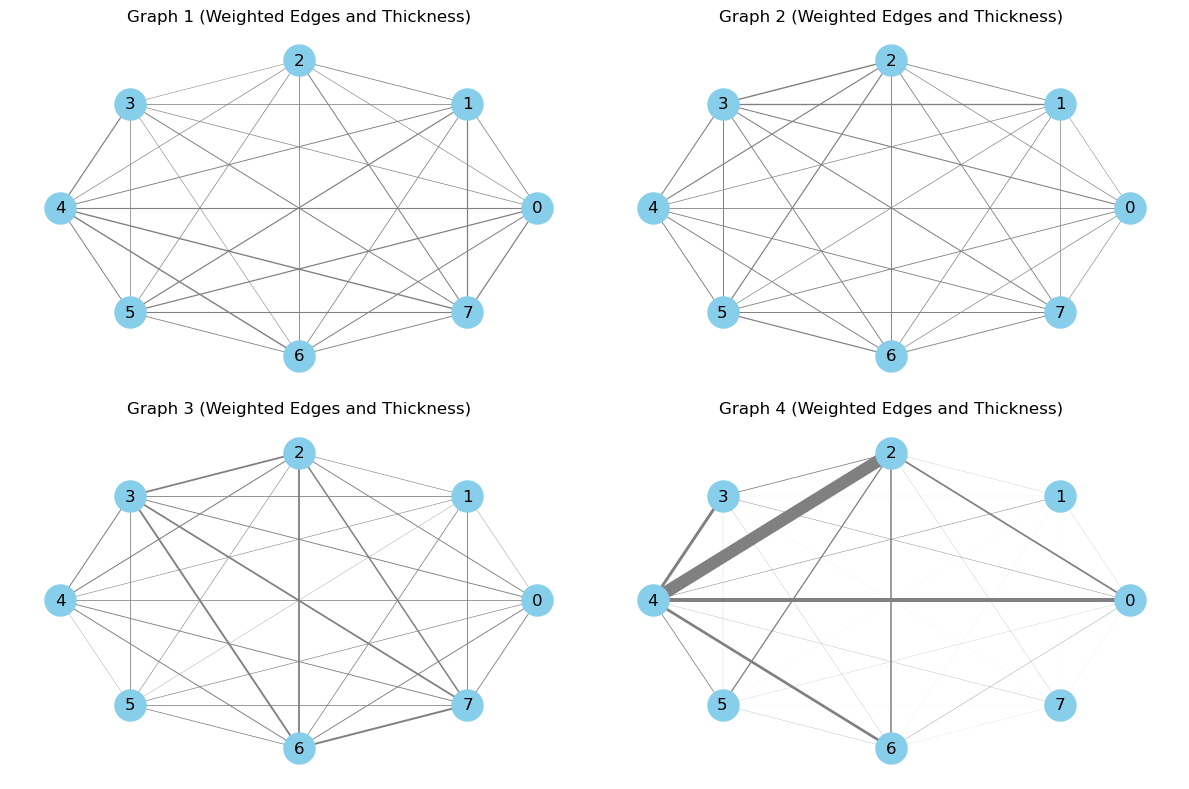

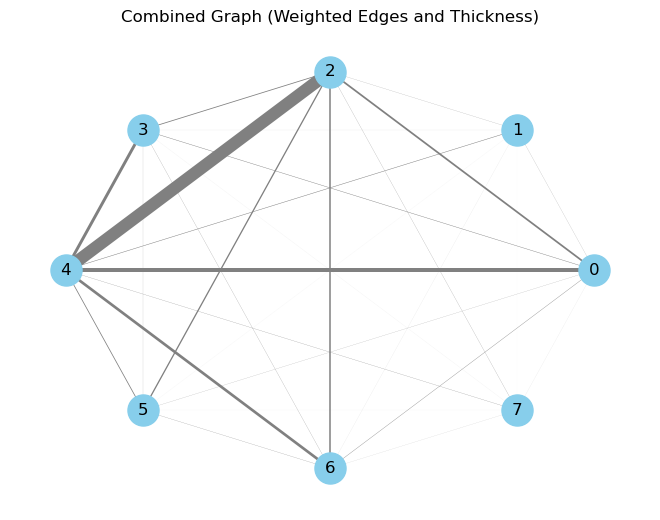

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.cm as cm
import numpy as np

# Example: four different datasets of node pairs (replace with your real data)
#datasets = np.array([MI_adj_random[490], MI_adj_greedy[490], MI_adj_mimic[490], MI_adj_landmax[490]]) #MI_adj_landmax[99]]) # Replace these with your actual datasets
datasets = np.array([MI_adj_random_time_avg, MI_adj_greedy_time_avg, MI_adj_mimic_time_avg, MI_adj_landmax_time_avg]) #MI_adj_landmax[99]]) # Replace these with your actual datasets
dataset_titles = ["Random MI", "Greedy MI", "Mimic MI", "Landmax MI"]

# Step 2: Create a graph for each adjacency matrix
G1 = nx.from_numpy_array(datasets[0])
G2 = nx.from_numpy_array(datasets[1])
G3 = nx.from_numpy_array(datasets[2])
G4 = nx.from_numpy_array(datasets[3])
# Step 3: Plot the graphs with weighted edges
plt.figure(figsize=(12, 8))

# Use a common layout for all graphs to have a consistent comparison
pos = nx.circular_layout(G1)

# Step 3: Define a function to adjust edge thickness based on the weights
def draw_graph_with_weights_and_thickness(G, pos, title):
    # Get the edge weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    
    # Use the edge weights to scale the thickness (choose a scaling factor)
    edge_thickness = [weight * 200 for weight in edge_weights.values()]  # Scale by 2 for visibility
    
    # Draw the nodes and edges with variable edge thickness
    nx.draw(G, pos, with_labels=True, node_color='skyblue', 
            node_size=500, font_size=12, width=edge_thickness, edge_color='gray')
    
    # Draw edge labels (weights)
   # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_color='red', font_size=10)
    plt.title(title)

# Step 4: Plot the graphs with variable edge thickness based on weights
plt.figure(figsize=(12, 8))

 #Use a common layout for all graphs
pos = nx.circular_layout(G1)

plt.subplot(221)
draw_graph_with_weights_and_thickness(G1, pos, "Graph 1 (Weighted Edges and Thickness)")

plt.subplot(222)
draw_graph_with_weights_and_thickness(G2, pos, "Graph 2 (Weighted Edges and Thickness)")

plt.subplot(223)
draw_graph_with_weights_and_thickness(G3, pos, "Graph 3 (Weighted Edges and Thickness)")

plt.subplot(224)
draw_graph_with_weights_and_thickness(G4, pos, "Graph 4 (Weighted Edges and Thickness)")

plt.tight_layout()
plt.show()

#\ Optionally, combine the graphs into one
combined_graph = nx.compose_all([G1, G2, G3, G4])

# Visualize the combined graph with weighted edges and variable thickness
plt.figure()
draw_graph_with_weights_and_thickness(combined_graph, pos, "Combined Graph (Weighted Edges and Thickness)")
plt.show()

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.cm as cm
import numpy as np

# Example: four different datasets of node pairs (replace with your real data)
datasets = [output_random[0][0:], output_greedy[0][0:], output_mimic[0][0:], output_landscape_maximizes[0][0:]]  # Replace these with your actual datasets
dataset_titles = ["Random Node Pairs", "Greedy Node Pairs", "Mimic Node Pairs", "Landmax Node Pairs"]

# Function to visualize each dataset
def visualize_network(dataset, ax, title, pos, cmap):
    # Flatten the dataset into a list of tuples representing pairs
    edges = [tuple(sorted(pair)) for sublist in dataset for pair in sublist]
    vmin=0
    vmax=495

    # Count the number of times each node pair appears
    edge_weights = Counter(edges)

    # Create a graph
    G = nx.Graph()

    # Add edges along with their weights
    for edge, weight in edge_weights.items():
        G.add_edge(edge[0], edge[1], weight=weight)

    edges = list(G.edges)

    # Get the edge weights to visualize them
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    # Normalize weights for color mapping
    norm = plt.Normalize(vmin, vmax)

    # Map edge weights to colors using the given colormap
    edge_colors = [cmap(norm(w)) for w in weights]

    # Draw the graph with node labels, use color to represent the weight
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500,
            edge_color=edge_colors, width=2, ax=ax)

    # Draw edge labels to show weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, ax=ax)

    # Add a color bar to show the weight scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Edge weight")

    # Add a title to each subplot
    ax.set_title(title)

    n_nodes = max(max(edge) for edge in edges) + 1  # Ensure it covers all nodes
    adj_matrix = np.zeros((n_nodes, n_nodes))

    for (edge, weight) in zip(edges, weights):
        adj_matrix[edge[0], edge[1]] = weight
        adj_matrix[edge[1], edge[0]] = weight
    print(f"Adjacency Matrix for {title}:\n{adj_matrix}\n")
    return adj_matrix
# Define the layout and figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid of subplots

# Generate a consistent node position layout across all datasets
# Flatten the datasets to extract individual nodes, assuming each sublist contains node pairs
all_nodes = set([node for dataset in datasets for sublist in dataset for pair in sublist for node in pair])
G_all = nx.Graph()
G_all.add_nodes_from(all_nodes)
pos = nx.spring_layout(G_all, seed=42)  # Fixed layout for nodes

# Colormaps for each dataset (optional: you can change these)
colormaps = [cm.Blues, cm.Blues, cm.Blues, cm.Blues]

# Store adjacency matrices for further processing
adjacency_matrices = []

# Visualize each dataset in its respective subplot and output the adjacency matrix
for i, dataset in enumerate(datasets):
    row, col = divmod(i, 2)
    adj_matrix = visualize_network(dataset, axs[row, col], dataset_titles[i], pos, colormaps[i])
    #store all adjacency matrices in a list
    adjacency_matrices.append(adj_matrix)  # Store the matrix in a list

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Further processing with adjacency_matrices if needed
# Now adjacency_matrices is a list of NumPy arrays


NameError: name 'output_random' is not defined

In [17]:
import networkx as nx
def laplacian_eigenvalues_eigenvector(adj_matrix):
    #give G a numpy array
    G = nx.from_numpy_array(adj_matrix)
    
    from scipy.linalg import eigh
    
    laplacians = [nx.laplacian_matrix(G).toarray()]
    
    # Step 2: Compute eigenvalues and eigenvectors for each Laplacian
    eigenvalues = []
    eigenvectors = []
    for lap in laplacians:
        eigvals, eigvecs = eigh(lap)  # eigh for symmetric matrices
        eigenvalues.append(eigvals)
        eigenvectors.append(eigvecs)
    return (eigenvalues,eigenvectors)

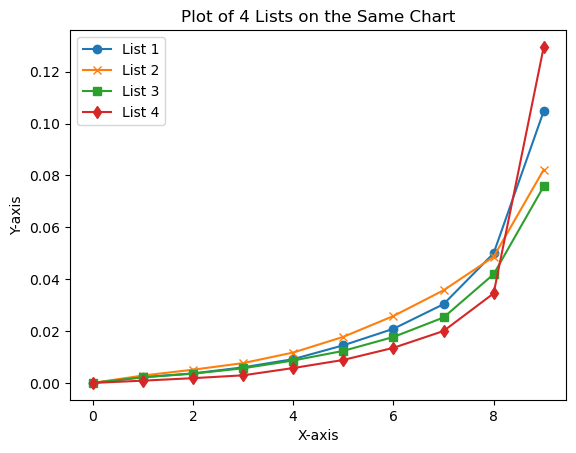

In [80]:
import matplotlib.pyplot as plt

# Example data (four lists of N points)
N = 10
x = list(range(N))  # X-axis points (0, 1, 2, ..., N-1)
y1 = average_laplacian_eigenvalues(np.array(MI_adj_random))[1]    # First list of N points
y2 = average_laplacian_eigenvalues(np.array(MI_adj_greedy))[1]   # Second list
y3 = average_laplacian_eigenvalues(np.array(MI_adj_mimic))[1]  # Third list
y4 = average_laplacian_eigenvalues(np.array(MI_adj_landmax))[1]  # Fourth list

# Plot each list on the same chart
plt.plot(x, y1, label='List 1', marker='o')  # Plot with markers
plt.plot(x, y2, label='List 2', marker='x')
plt.plot(x, y3, label='List 3', marker='s')
plt.plot(x, y4, label='List 4', marker='d')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of 4 Lists on the Same Chart')

# Add a legend to distinguish between the lists
plt.legend()

# Show the plot
plt.show()

In [76]:
y4

array([-7.69540837e-19,  2.17138767e-03,  4.43133671e-03,  7.41910540e-03,
        1.12952712e-02,  1.63680576e-02,  2.26732932e-02,  3.03881994e-02,
        4.62007037e-02,  9.40140476e-02])

In [77]:
def average_laplacian_eigenvalues(MI_adj_matrices):
    laplacian_eig_vals =[]
    for i in range (len(MI_adj_matrices)):
        laplacian_eig_vals.append(laplacian_eigenvalues_eigenvector(np.array(MI_adj_matrices[i]))[0][0])
    return (laplacian_eig_vals,np.mean(laplacian_eig_vals,axis=0))
        

In [84]:
def average_laplacian_eigenvalues_full_sim(twoQdms, num_nodes,trials):
    averages_of_each_trial=[]
    for j in range(trials):
        MI_adj_matrices = adjacency_matrices_list_two_dim(twoQdms,j,num_nodes, mutual_info_dicts)
        laplacian_eig_vals =[]
        for i in range (len(MI_adj_matrices)):
            laplacian_eig_vals.append(laplacian_eigenvalues_eigenvector(np.array(MI_adj_matrices[i]))[0][0])
        return (np.mean(laplacian_eig_vals,axis=0))
        average_of_each_trial.append(np.mean(laplacian_eig_vals,axis=0))
    return average_or_each_trial

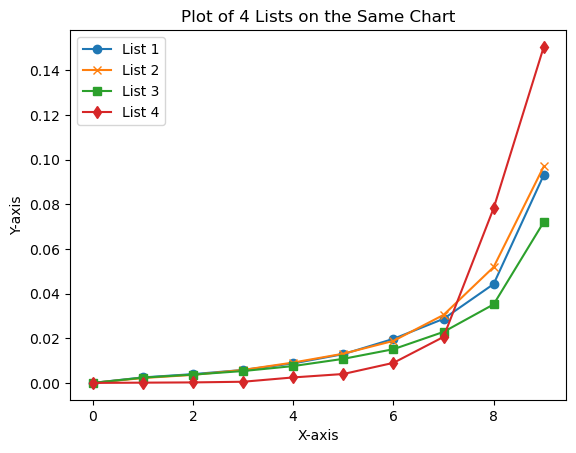

In [100]:
# Example data (four lists of N points)
N = 10
x = list(range(N))  # X-axis points (0, 1, 2, ..., N-1)
y1 = average_laplacian_eigenvalues_full_sim(twoQdmsrandom,10,99)   # First list of N points
y2 = average_laplacian_eigenvalues_full_sim(twoQdmsgreedy,10,99)   # Second list
y3 = average_laplacian_eigenvalues_full_sim(twoQdmsmimic,10,99)  # Third list
y4 = average_laplacian_eigenvalues_full_sim(twoQdmslandscape_max,10,99) # Fourth list

# Plot each list on the same chart
plt.plot(x, y1, label='List 1', marker='o')  # Plot with markers
plt.plot(x, y2, label='List 2', marker='x')
plt.plot(x, y3, label='List 3', marker='s')
plt.plot(x, y4, label='List 4', marker='d')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of 4 Lists on the Same Chart')

# Add a legend to distinguish between the lists
plt.legend()

# Show the plot
plt.show()



In [ ]:
C2
#greedy>random>mimic>landmax

In [92]:
[y1[1],y2[1],y3[1],y4[1]]

[0.001522385627732711,
 0.001915538111687492,
 8.645540467683299e-05,
 7.568619248345553e-05]

In [ ]:
C4
#random>greedy>mimic>landmax

In [95]:
[y1[1],y2[1],y3[1],y4[1]]

[0.0025726596927071956,
 0.0020486540666823563,
 0.0018505570698767277,
 0.0011456167349055994]

In [ ]:
C5
#random>greedy>mimic>landmax

In [98]:
[y1[1],y2[1],y3[1],y4[1]]

[0.0027548608326642466,
 0.002493382350145323,
 0.0022260821583622017,
 0.00043979819461462913]

In [ ]:
C6
#random>mimic>greedy>landmax

In [101]:
[y1[1],y2[1],y3[1],y4[1]]

[0.0024627931034016657,
 0.00219026404705494,
 0.002370523352992928,
 0.00011963152357526147]

In [ ]:
CN
#mimic>greedy>random>landmax

In [89]:
[y1[1],y2[1],y3[1],y4[1]]

[0.0016108839654067608,
 0.0024409811477916787,
 0.0026739375882804946,
 0.00037288444172929434]

In [145]:
#Clustering Coefficient
def clustering_coeff_function_of_time(adjacency_matrix_list):
    C_list = []
    #adjacency_matrix_list=np.array(adjacency_matrix_list)
    for adj_mat in adjacency_matrix_list:
        adj_mat=np.array(adj_mat)
        M_sq = adj_mat@adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat@adj_mat@adj_mat
        M_cube_trace = np.trace(M_cube)
        C_list.append(M_cube_trace/sum_of_M_sq)
    return(C_list)

#Disparity
def disparity_function_of_time(adjacency_matrix_list, N):
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return D_list

In [192]:
def mean_std_per_qubit(concurrence_adj,num_qbits):
    mean_std_list=[]
    for adj_mat in concurrence_adj:
        mean_std_per_q_at_t=[]
        for q_index in range(num_qbits):
            mean_conc = np.mean(adj_mat[q_index])
            std_conc = np.std(adj_mat[q_index])
            max_conc = np.max(adj_mat[q_index])
            min_conc=np.min(adj_mat[q_index])
            mean_std_per_q_at_t.append([mean_conc,std_conc,max_conc,min_conc])
        mean_std_list.append(mean_std_per_q_at_t)
    return mean_std_list

In [147]:
def mean_conc_per_Q(mean_stds_conc):
    mean_conc_list = []
    for mean_std in mean_stds_conc:
        mean_at_that_time_step = []
        for mean_of_q in mean_std:
            mean_at_that_time_step.append(mean_of_q[0])
        mean_conc_list.append(mean_at_that_time_step)
    return mean_conc_list

In [148]:
mean_stds_MI_random= mean_std_per_qubit(MI_adj_random,8)
mean_stds_MI_greedy= mean_std_per_qubit(MI_adj_greedy,8)
mean_stds_MI_mimic= mean_std_per_qubit(MI_adj_mimic,8)
mean_stds_MI_landscape_max= mean_std_per_qubit(MI_adj_landmax,8)

In [149]:
mean_MI_random=mean_conc_per_Q(mean_stds_MI_random)
mean_MI_greedy=mean_conc_per_Q(mean_stds_MI_greedy)
mean_MI_mimic=mean_conc_per_Q(mean_stds_MI_mimic)
mean_MI_landmax=mean_conc_per_Q(mean_stds_MI_landscape_max)

In [33]:
def conc_stats_of_Q(means_stds_conc,Q):
    conc_stats = []
    for mean_std_conc in means_stds_conc:
        conc_stats.append(mean_std_conc[Q])
    return conc_stats

In [34]:
conc_stats_Q_random=conc_stats_of_Q(mean_stds_conc_random,2);
conc_stats_Q_greedy=conc_stats_of_Q(mean_stds_conc_greedy,2);

In [32]:
def plot_conc_stats_of_Q(conc_stats_Q):
    time_steps = np.arange(0,100)
    mean_stat=[]
    std_stat=[]
    max_stat=[]
    min_stat=[]
    for conc_stat in conc_stats_Q:
        mean_stat.append(conc_stat[0])
        std_stat.append(conc_stat[1])
        max_stat.append(conc_stat[2])
        min_stat.append(conc_stat[3])
    return mean_stat,std_stat,max_stat,min_stat
    
   
    

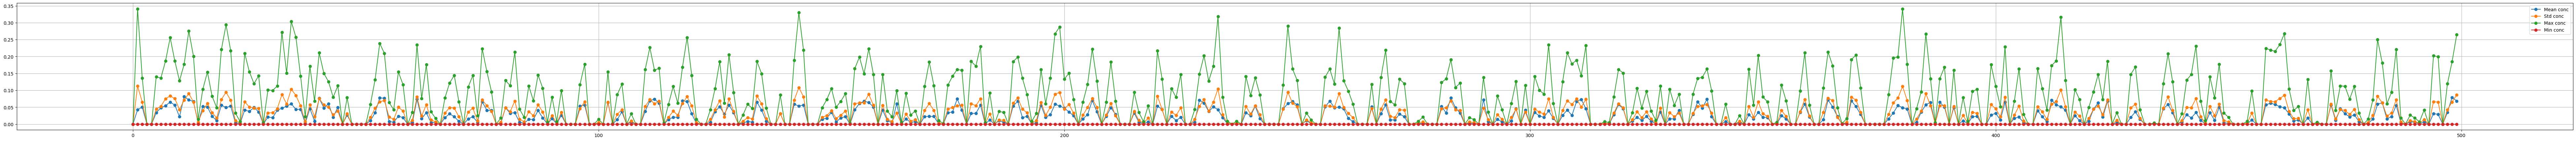

In [47]:

conc_stats_Q=conc_stats_of_Q(mean_stds_MI_random,3);time_steps = np.arange(0,500)
plt.figure(figsize=(100, 5))
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[0], '-o', label='Mean conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[1], '-o', label='Std conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[2], '-o', label='Max conc')
plt.plot(time_steps, plot_conc_stats_of_Q(conc_stats_Q)[3], '-o', label='Min conc')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
MI_adj_random=adjacency_matrices_list_two_dim(twoQdmsrandom,19,10, mutual_info_dicts)
MI_adj_greedy=adjacency_matrices_list_two_dim(twoQdmsgreedy,19,10, mutual_info_dicts)
MI_adj_mimic=adjacency_matrices_list_two_dim(twoQdmsmimic,19,10, mutual_info_dicts)
MI_adj_landmax=adjacency_matrices_list_two_dim(twoQdmslandscape_max,19,10, mutual_info_dicts)

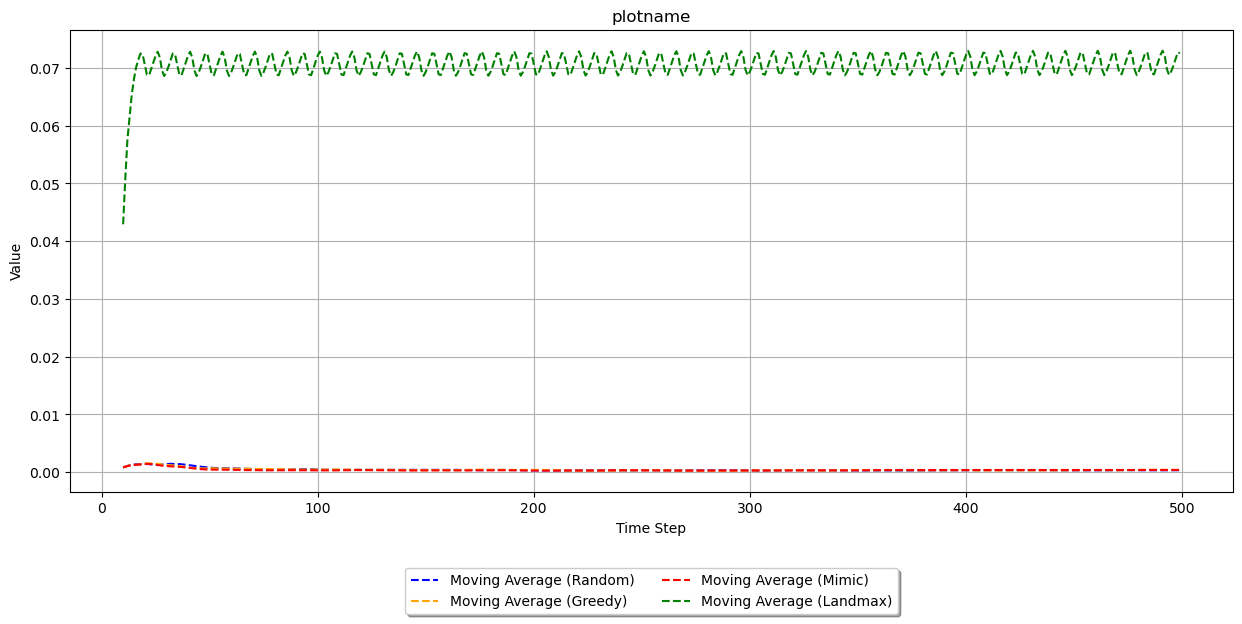

NameError: name 'plot_stats_as_function_of_time_avg' is not defined

In [51]:
steps=499
size=[8]
conc_std_random=extract_means(means_stds_mode_of_pops_of_one_sim_index(mean_MI_random))
conc_std_greedy=extract_means(means_stds_mode_of_pops_of_one_sim_index(mean_MI_greedy))
conc_std_mimic=extract_means(means_stds_mode_of_pops_of_one_sim_index(mean_MI_mimic))
conc_std_landmax=extract_means(means_stds_mode_of_pops_of_one_sim_index(mean_MI_landmax))
        
plot_four_stats_as_function_of_time_avg(conc_std_random,conc_std_greedy,conc_std_mimic,conc_std_landmax,filename = 'conc_mean')
plot_stats_as_function_of_time_avg(conc_std_landmax,filename = 'conc_mean')

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_22201/1734428674.py:11: RuntimeWarning: invalid value encountered in scalar divide
  C_list.append(M_cube_trace/sum_of_M_sq)


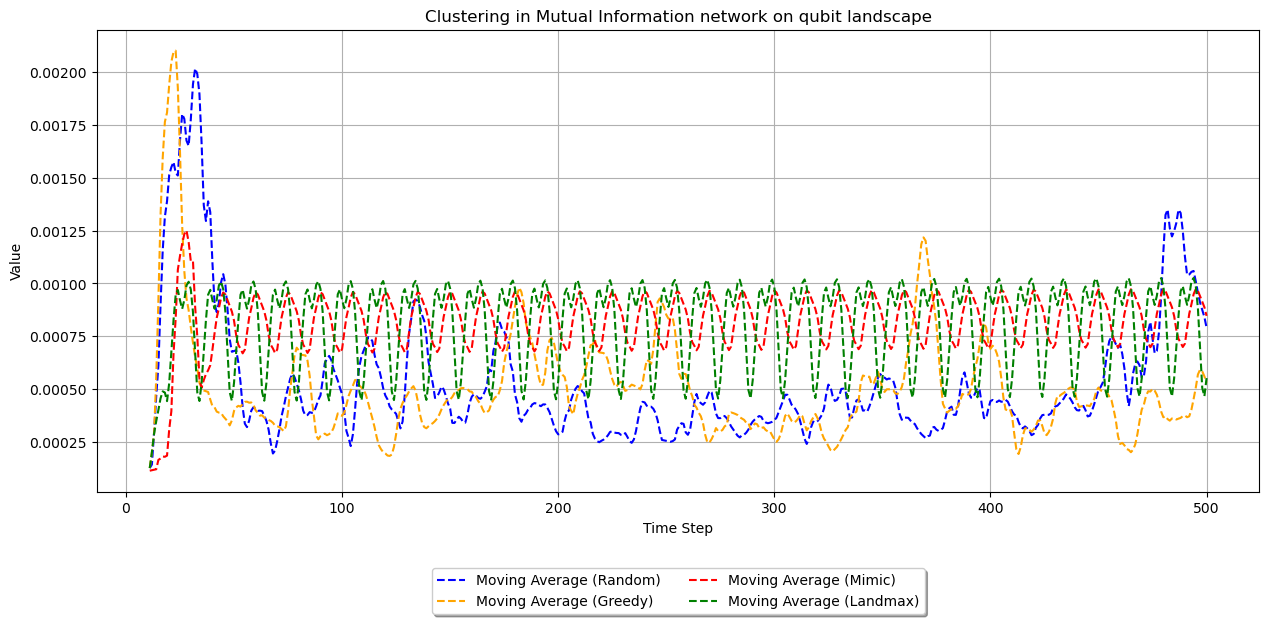

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_22201/1734428674.py:21: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


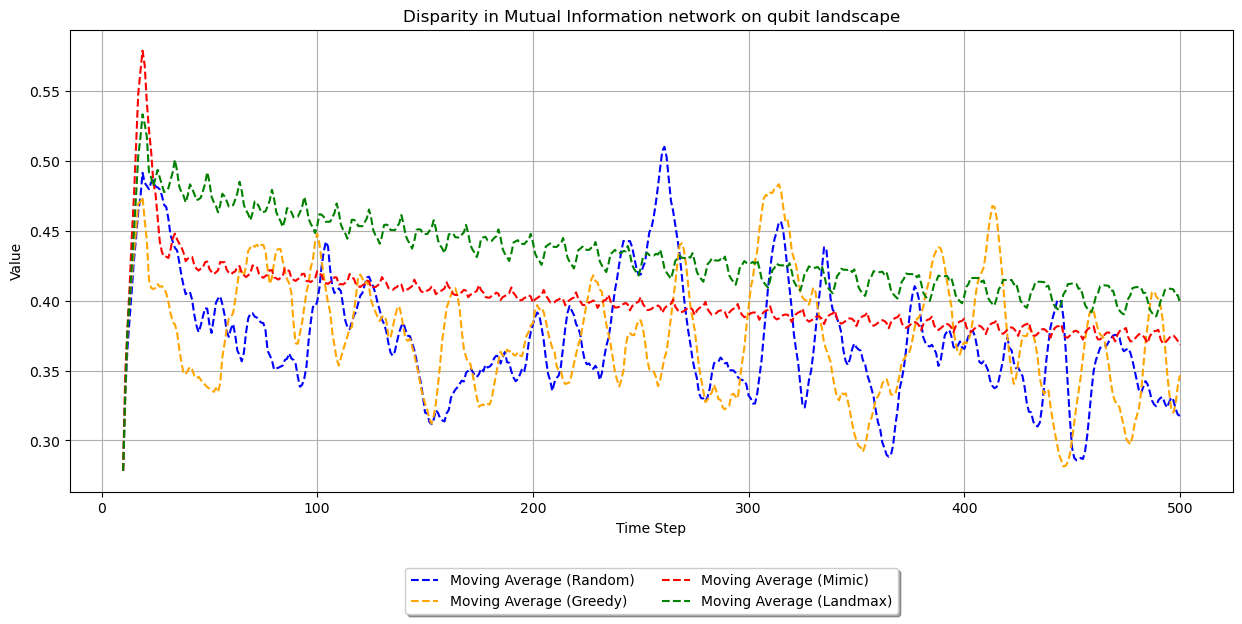

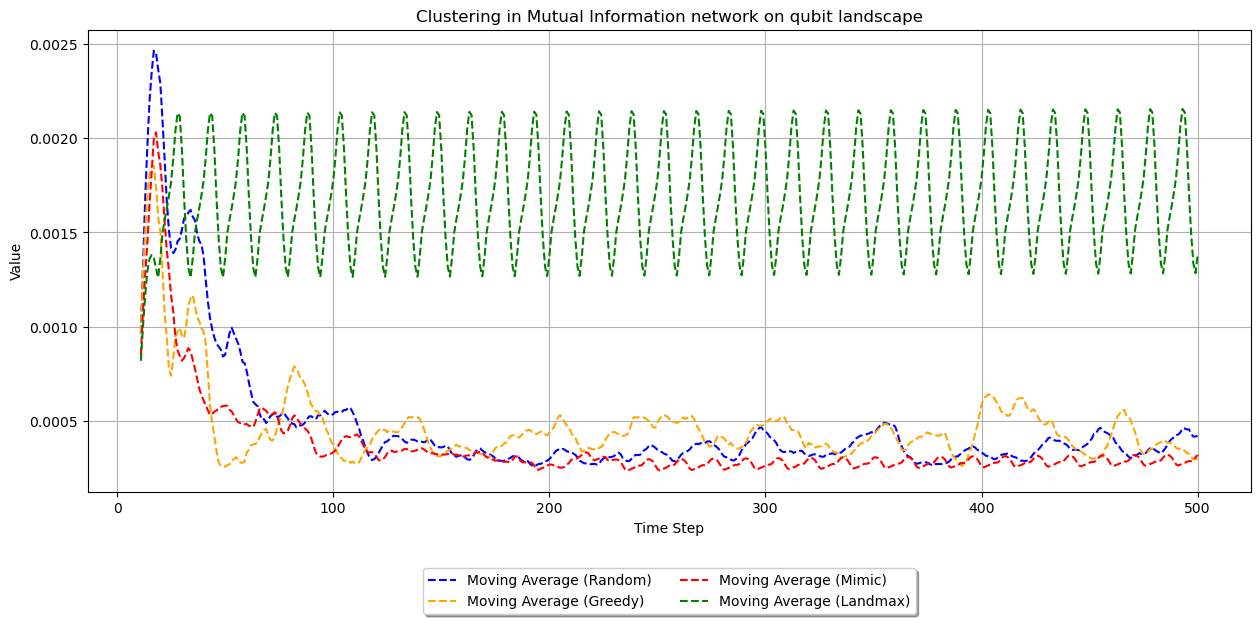

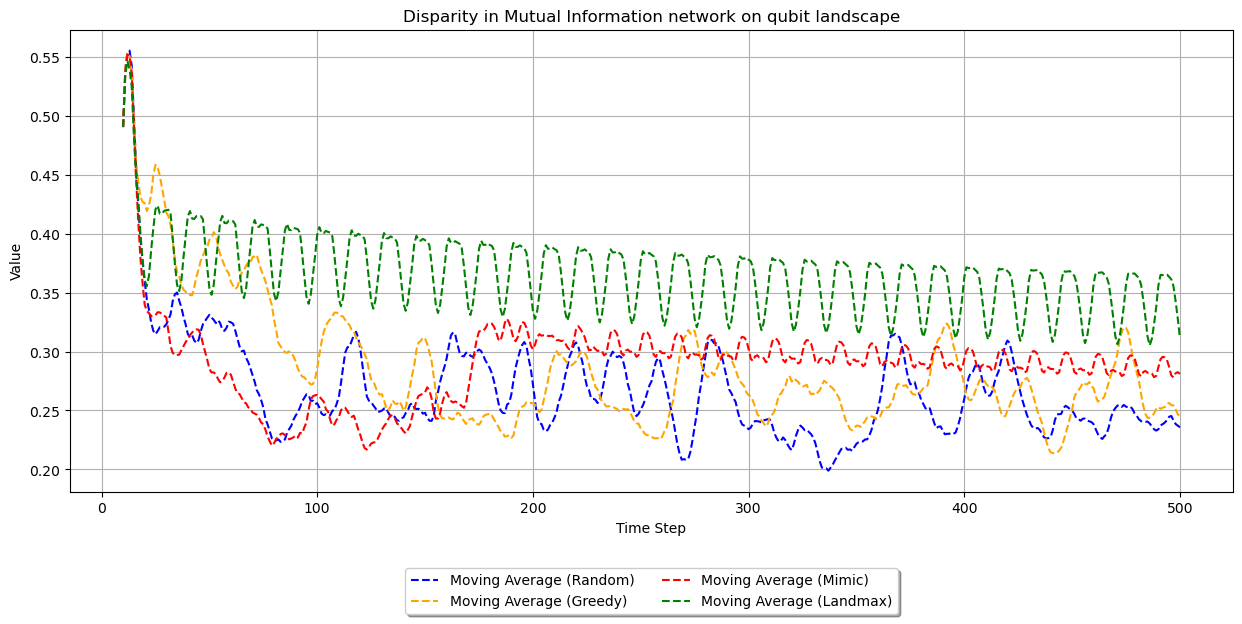

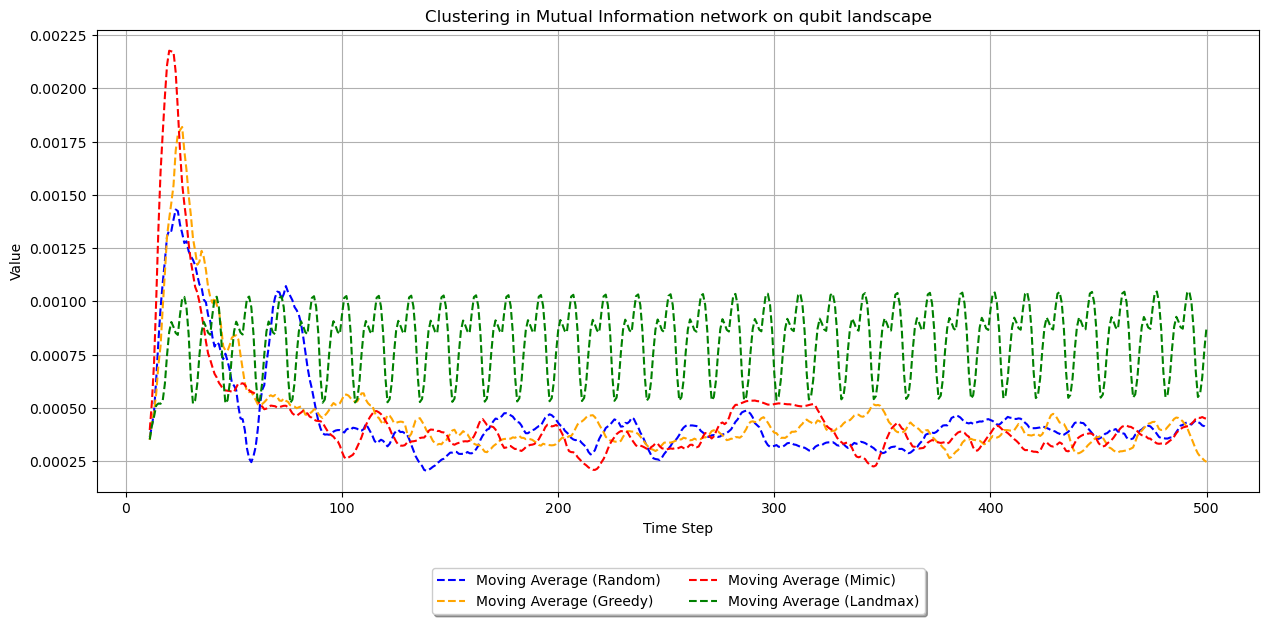

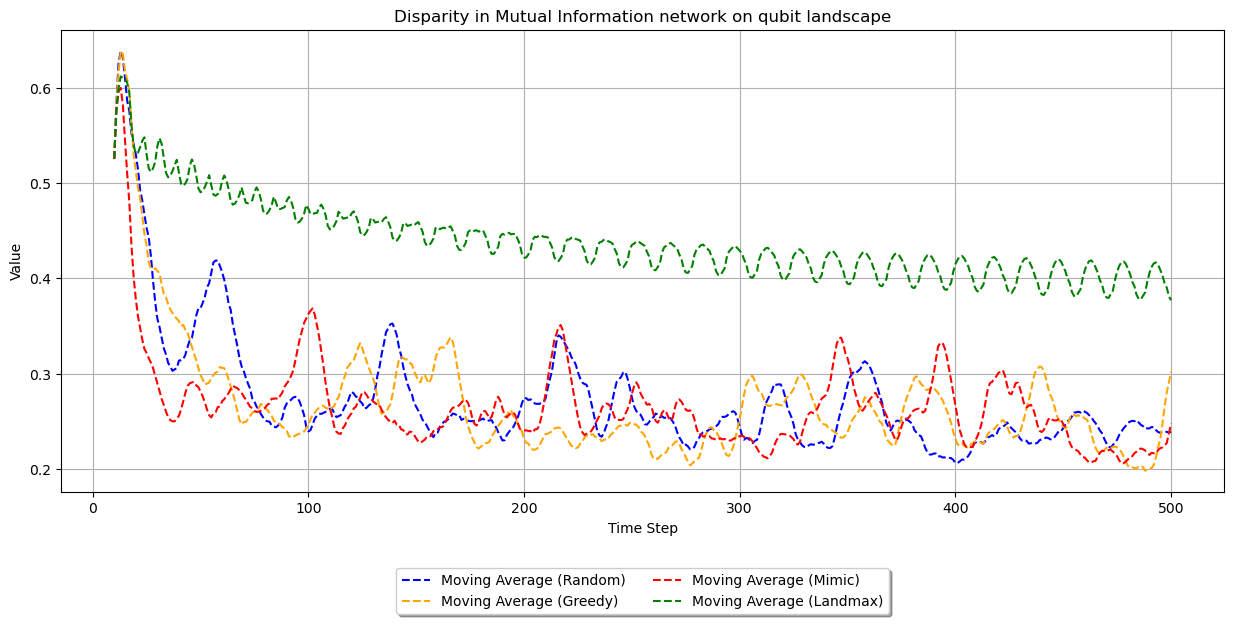

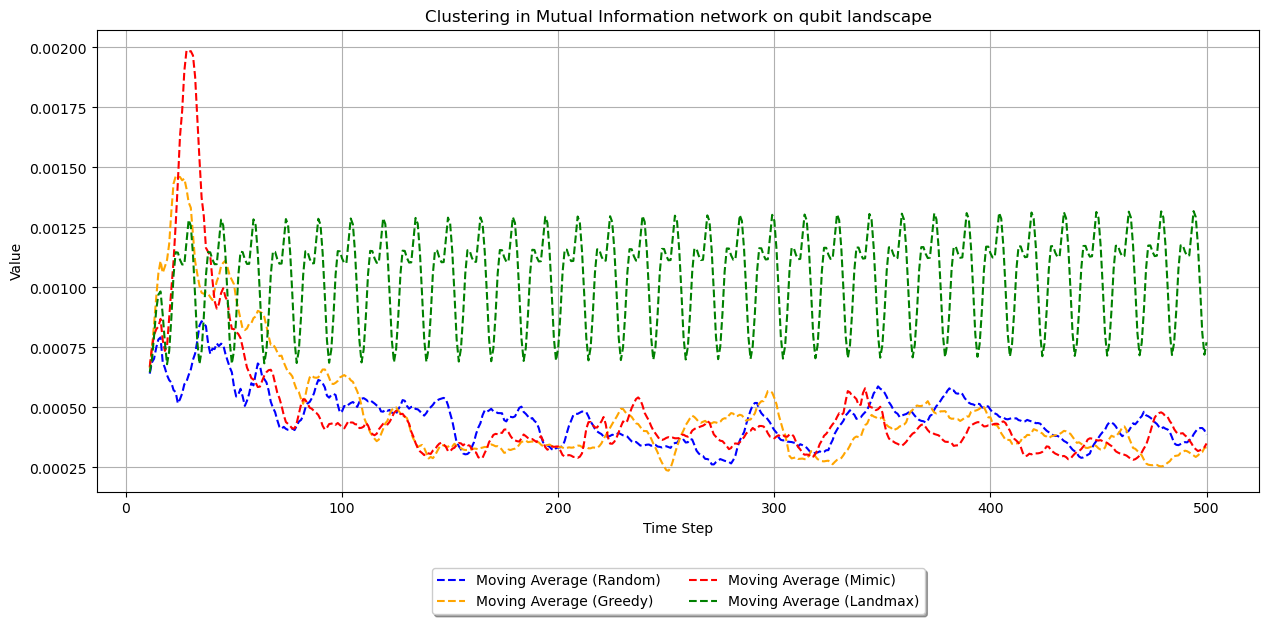

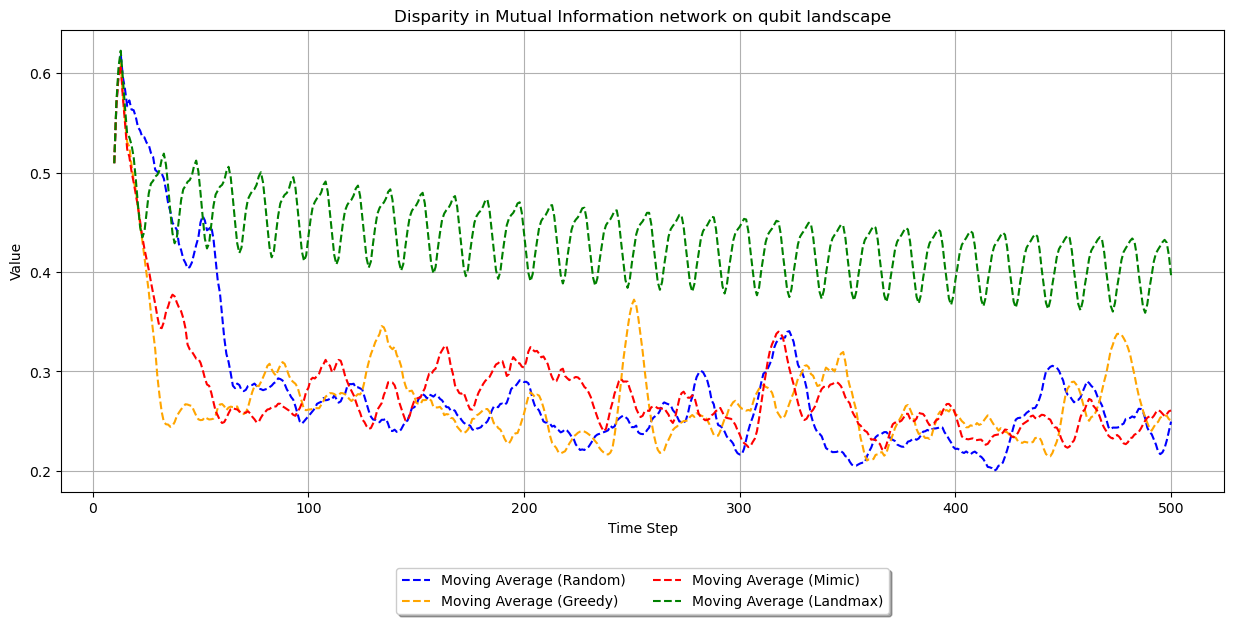

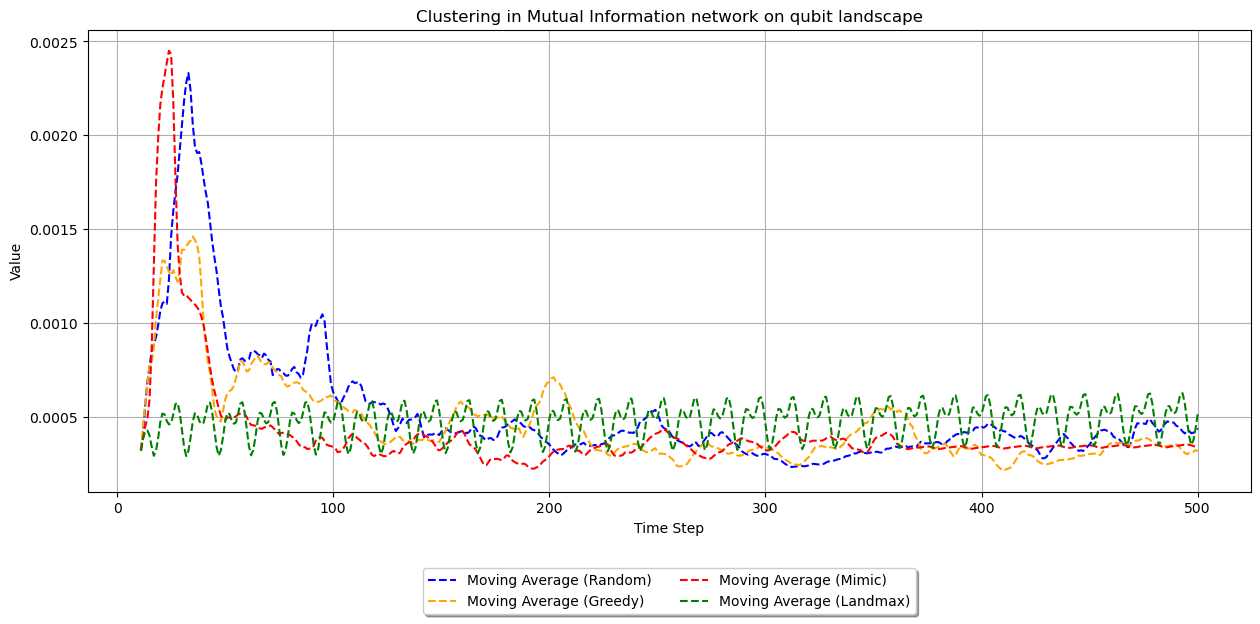

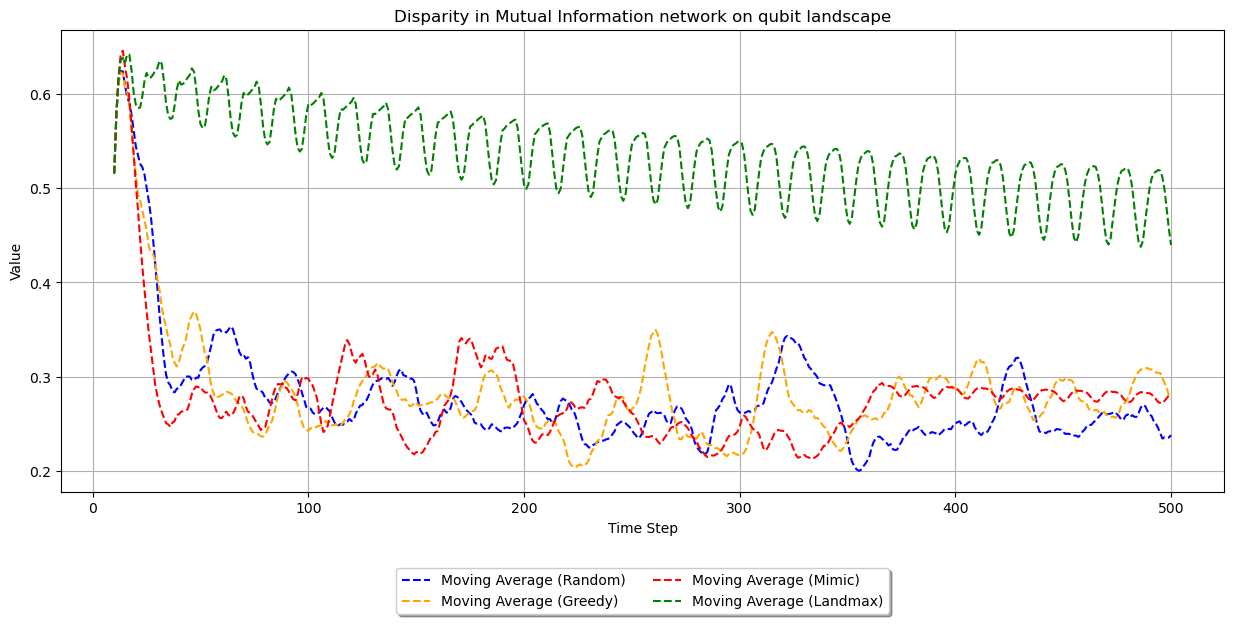

In [26]:
num_nodes=8
list_conn = ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
for conn in list_conn:
    twoQdmsrandom = get_2_qbit_dms(newdata1,8,conn,"random")
    twoQdmsgreedy = get_2_qbit_dms(newdata2,8,conn,"greedy")
    twoQdmslandmax = get_2_qbit_dms(newdata4,8,conn,"landscape_maximizes")
    twoQdmsmimic = get_2_qbit_dms(newdata3,8,conn,"mimic")
    #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")

    adj_matrices_list_greedy = adjacency_matrices_list_two_dim(twoQdmsgreedy,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_random = adjacency_matrices_list_two_dim(twoQdmsrandom,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_landmax = adjacency_matrices_list_two_dim(twoQdmslandmax,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_mimic = adjacency_matrices_list_two_dim(twoQdmsmimic,0, num_nodes,mutual_info_dicts)
    #C5
    clustering_greedy = clustering_coeff_function_of_time(np.array(adj_matrices_list_greedy))
    clustering_random = clustering_coeff_function_of_time(np.array(adj_matrices_list_random))
    clustering_landmax = clustering_coeff_function_of_time(np.array(adj_matrices_list_landmax))
    clustering_mimic= clustering_coeff_function_of_time(np.array(adj_matrices_list_mimic))
    print()
    #plot_four_stats_as_function_of_time(clustering_random,clustering_greedy, clustering_landmax,clustering_mimic, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(clustering_random,clustering_greedy, clustering_mimic,clustering_landmax, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    plt.show()
    
    #C5
    disparity_greedy = disparity_function_of_time(np.array(adj_matrices_list_greedy),8)
    disparity_random = disparity_function_of_time(np.array(adj_matrices_list_random),8)
    disparity_landmax = disparity_function_of_time(np.array(adj_matrices_list_landmax),8)
    disparity_mimic = disparity_function_of_time(np.array(adj_matrices_list_mimic),8)
    #plot_four_stats_as_function_of_time(disparity_random,disparity_greedy, disparity_landmax,disparity_mimic, filename='disparity_c5_temp_var',title = 'Disparity in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(disparity_random,disparity_greedy, disparity_mimic,disparity_landmax, filename='disparity_c5_temp_var_avg',title = 'Disparity in Mutual Information network on qubit landscape')
    plt.show()

In [36]:
np.max(np.array([MI_adj_random[99], MI_adj_greedy[99], MI_adj_mimic[99], MI_adj_landmax[99]]))  # Replace with your desired minimum value


0.08432014008004196

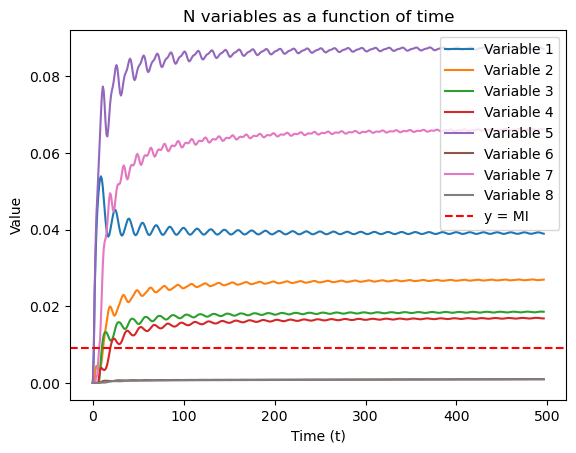

In [51]:
def MItotal(MI_adj):
    MI_adj_tot=[]
    for i in range(499):
       MI_adj_tot.append(np.sum(MI_adj[i],axis=0))
    return np.array(MI_adj_tot)


t = np.arange(400)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data=time_averaged_one_point_measures_matrix_full_sim(MItotal(MI_adj_landmax))
num_time_steps = len(data)-2  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data=np.array(data[1:498])

import matplotlib.pyplot as plt
import numpy as np

data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]


# Plot each number as a function of t
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}')

plt.axhline(y=(0.254601)/28, color='r', linestyle='--', label='y = MI')


# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()

# Show the plot
plt.show()

In [363]:
data1[498]/2

0.10005624963094323

In [ ]:
def MItotal(MI_adj):
    MI_adj_tot=[]
    for i in range(499):
       MI_adj_tot.append(np.sum(MI_adj[i],axis=0)/2)
    return np.array(MI_adj_tot)


t = np.arange(400)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data1=time_averaged_one_point_measures_matrix_full_sim(np.sum(MItotal(MI_adj_random1),axis=1))
data2=time_averaged_one_point_measures_matrix_full_sim(np.sum(MItotal(MI_adj_random2),axis=1))
#data3=time_averaged_one_point_measures_matrix_full_sim(np.sum(MItotal(MI_adj_landmax),axis=1))
data3=time_averaged_one_point_measures_matrix_full_sim(np.sum(MItotal(MI_adj_mimic),axis=1))

num_time_steps = len(data)# The number of rows in the data corresponds to the number of time steps
t = np.arange(499)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

import matplotlib.pyplot as plt
import numpy as np

# Plot each number as a function of t
for y_values in data:
    plt.plot(t, data1)
    plt.plot(t, data2)
    plt.plot(t, data3)

plt.axhline(y=0.254601, color='r', linestyle='--', label='y = MI')


# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()

# Show the plot
plt.show()

In [83]:
from scipy.stats import pearsonr, spearmanr
def normalize_by_row(matrix):
    row_sums = matrix.sum(axis=1)
    normalized_matrix = matrix / row_sums[:, np.newaxis]
    return normalized_matrix



adj_matrix_MI = (np.array(MI_adj_landmax[99]))
adj_matrix_IN =(np.array([[0.  , 0.01, 0.  , 0.02, 0.92, 0.  , 0.01, 0.01, 0.02, 0.  ],
       [0.01, 0.  , 0.02, 0.  , 0.  , 0.02, 0.02, 0.92, 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.02, 0.  , 0.92, 0.  , 0.01, 0.  , 0.02],
       [0.02, 0.  , 0.02, 0.  , 0.01, 0.02, 0.  , 0.  , 0.01, 0.91],
       [0.92, 0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.02],
       [0.  , 0.02, 0.92, 0.02, 0.01, 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.01, 0.02, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.92, 0.03],
       [0.01, 0.92, 0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.02, 0.01],
       [0.02, 0.  , 0.  , 0.01, 0.01, 0.01, 0.92, 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.91, 0.02, 0.  , 0.03, 0.01, 0.  , 0.  ]]))

flat_matrix_MI = adj_matrix_MI.flatten()
flat_matrix_IN = adj_matrix_IN.flatten()

# Step 2: Calculate Pearson correlation
pearson_corr, _ = pearsonr(flat_matrix_MI, flat_matrix_IN)
print(f"Pearson Correlation: {pearson_corr}")

# Step 3: Calculate Spearman correlation
spearman_corr, _ = spearmanr(flat_matrix_MI, flat_matrix_IN)
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: -0.10716429018673174
Spearman Correlation: 0.1522126720154731


In [84]:
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Flatten the adjacency matrices
flat_matrix_MI = (adj_matrix_MI.flatten().reshape(1, -1))
flat_matrix_IN = (adj_matrix_IN.flatten().reshape(1, -1))

# Step 2: Compute cosine similarity
cosine_sim = cosine_similarity(flat_matrix_MI, flat_matrix_IN)
print(f"Cosine Similarity: {cosine_sim[0][0]}")

Cosine Similarity: 0.02052002514519103


In [ ]:
PauliZPauliZ=[[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]];
PauliZId=[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]];
IdPauliZ=[[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]];

In [181]:
#def extract_total(list_of_lists):
 #   return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    sublists=[]
    for sublist in list_of_lists:
        subsublists=[]
        for subsublist in sublist:
            subsublists.append(subsublist[0])
        sublists.append(subsublists)
    return sublists
#def extract_mode(list_of_lists):
 #   return [sublist[3] for sublist in list_of_lists]

In [193]:
MI_adj_random=adjacency_matrices_list_two_dim(twoQdmsrandom,89,8, mutual_info_dicts)
MI_adj_greedy=adjacency_matrices_list_two_dim(twoQdmsgreedy,89,8, mutual_info_dicts)
MI_adj_mimic=adjacency_matrices_list_two_dim(twoQdmsmimic,89,8, mutual_info_dicts)
MI_adj_landmax=adjacency_matrices_list_two_dim(twoQdmslandscape_max,89,8, mutual_info_dicts)

mean_stds_MI_random= mean_std_per_qubit(MI_adj_random,8)
mean_stds_MI_greedy= mean_std_per_qubit(MI_adj_greedy,8)
mean_stds_MI_mimic= mean_std_per_qubit(MI_adj_mimic,8)
mean_stds_MI_landscape_max= mean_std_per_qubit(MI_adj_landmax,8)


In [293]:
extract_means(mean_stds_MI_random);

In [28]:
import numpy as np
import math

def time_averaged_one_point_measures_at_t(dataset,t):
    # Assuming dataset is list of 100 lists i.e. one trial
    #stack datasets in 3D
    # Take the ensemble average along the first axis (averaging over all datasets)
    sum_till_t = np.sum(dataset[:t], axis=0)
    time_average_t = (1/(t+1))*(sum_till_t)
    return (time_average_t)

def time_averaged_one_point_measures_matrix_full_sim(dataset):
    # Take the ensemble average along the first axis (averaging over all datasets)
    time_average=[]
    for t in range(len(dataset)):
        time_average.append(time_averaged_one_point_measures_at_t(dataset,t))
    return (time_average)

data=time_averaged_one_point_measures_matrix_full_sim(extract_means(mean_stds_MI_mimic))
num_time_steps = len(data)-2  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data=np.array(data[1:499])
plt.figure(figsize=(20, 8))


data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]

 # Calculate the mean and standard deviation of the data at each time step
mean_values = np.mean(data_transposed, axis=0)
std_dev_values = np.std(data_transposed, axis=0)

import matplotlib.pyplot as plt
import numpy as np



# Plot each number as a function of t
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}')

plt.fill_between(t, 0.003 - std_dev_values, 0.003 + std_dev_values, color='pink', alpha=0.3, label='Variation (± std dev)')


plt.axhline(y=(0.254601)/28, color='r', linestyle='--', label='y = MI')


# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()

# Show the plot
plt.show()

NameError: name 'mean_stds_MI_mimic' is not defined

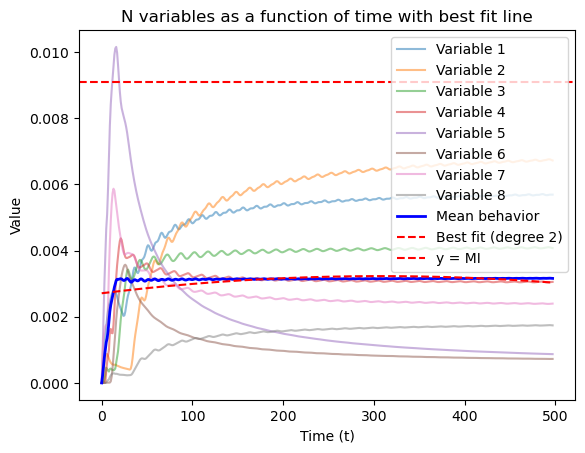

Best fit polynomial (degree 2):             2
-5.467e-09 x + 3.366e-06 x + 0.00271


In [334]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is extracted and processed already
data = time_averaged_one_point_measures_matrix_full_sim(extract_means(mean_stds_MI_mimic))
num_time_steps = len(data) - 2  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data = np.array(data[1:499])
data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]

# Calculate the mean behavior at each time step (mean over all variables)
mean_behavior = np.mean(data_transposed, axis=0)

# Perform a polynomial fit (degree 2 for example, you can adjust this)
degree = 2  # Adjust the degree based on how well the curve fits
coefficients = np.polyfit(t, mean_behavior, degree)
polynomial = np.poly1d(coefficients)

# Generate the fitted values
fitted_values = polynomial(t)

# Plot each variable as a function of time
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}', alpha=0.5)  # Reduce alpha for clarity

# Plot the mean behavior
plt.plot(t, mean_behavior, label='Mean behavior', color='blue', linewidth=2)

# Plot the best-fit line
plt.plot(t, fitted_values, label=f'Best fit (degree {degree})', color='red', linestyle='--')

# Plot the constant line y = MI
plt.axhline(y=(0.254601) / 28, color='r', linestyle='--', label='y = MI')

# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time with best fit line')
plt.legend()

# Show the plot
plt.show()

# Print the best fit equation
print(f"Best fit polynomial (degree {degree}): {polynomial}")


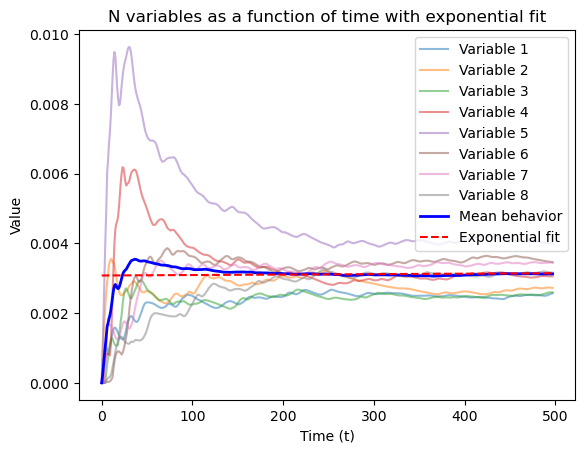

Best fit parameters: a = 0.2680058645041698, b = 4.798711698009281e-07, c = -0.264925333942426


In [335]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_func(t, a, b, c):
    return a * np.exp(b * t) + c

# Assuming data is already loaded and processed
data = time_averaged_one_point_measures_matrix_full_sim(extract_means(mean_stds_MI_random))
num_time_steps = len(data) - 2  # The number of rows in the data corresponds to the number of time steps
t = np.arange(num_time_steps)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data = np.array(data[1:499])
data_transposed = data.T  # Now rows are [x1_all_times, x2_all_times, ..., xN_all_times]

# Calculate the mean behavior at each time step (mean over all variables)
mean_behavior = np.mean(data_transposed, axis=0)

# Fit the exponential function to the data
popt, pcov = curve_fit(exponential_func, t, mean_behavior, p0=(1, 0.01, 1))

# Get the fitted parameters
a, b, c = popt

# Generate fitted values
fitted_values = exponential_func(t, *popt)

# Plot each variable as a function of time
for i, y_values in enumerate(data_transposed):
    plt.plot(t, y_values, label=f'Variable {i+1}', alpha=0.5)  # Reduce alpha for clarity

# Plot the mean behavior
plt.plot(t, mean_behavior, label='Mean behavior', color='blue', linewidth=2)

# Plot the best-fit line (exponential)
plt.plot(t, fitted_values, label='Exponential fit', color='red', linestyle='--')

# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time with exponential fit')
plt.legend()

# Show the plot
plt.show()

# Print the best fit parameters
print(f"Best fit parameters: a = {a}, b = {b}, c = {c}")


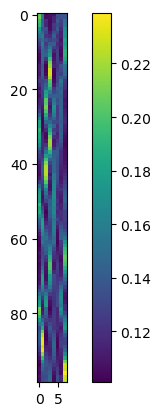

In [213]:
#for conn in list_conn:
#for size in sizes:
pops = get_pops(newdata2,8,"c2_2local","greedy")
for i in range(1):
    plt.imshow(pops[i][400:499], interpolation='none')
    plt.colorbar()
    plt.show()

In [222]:
def tracedistfrom_therm(pops):
    return [np.sum(np.abs(np.array(popst)-np.array([0.1375,0.1375,0.1375,0.1375,0.1375,0.1375,0.1375,0.1375]))) for popst in pops]


In [250]:
popsg = get_pops(newdata2,8,"c2_2local","greedy")
popsr = get_pops(newdata1,8,"c2_2local","random")
popsm = get_pops(newdata3,8,"c2_2local","mimic")
popsl = get_pops(newdata4,8,"c2_2local","landscape_maximizes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


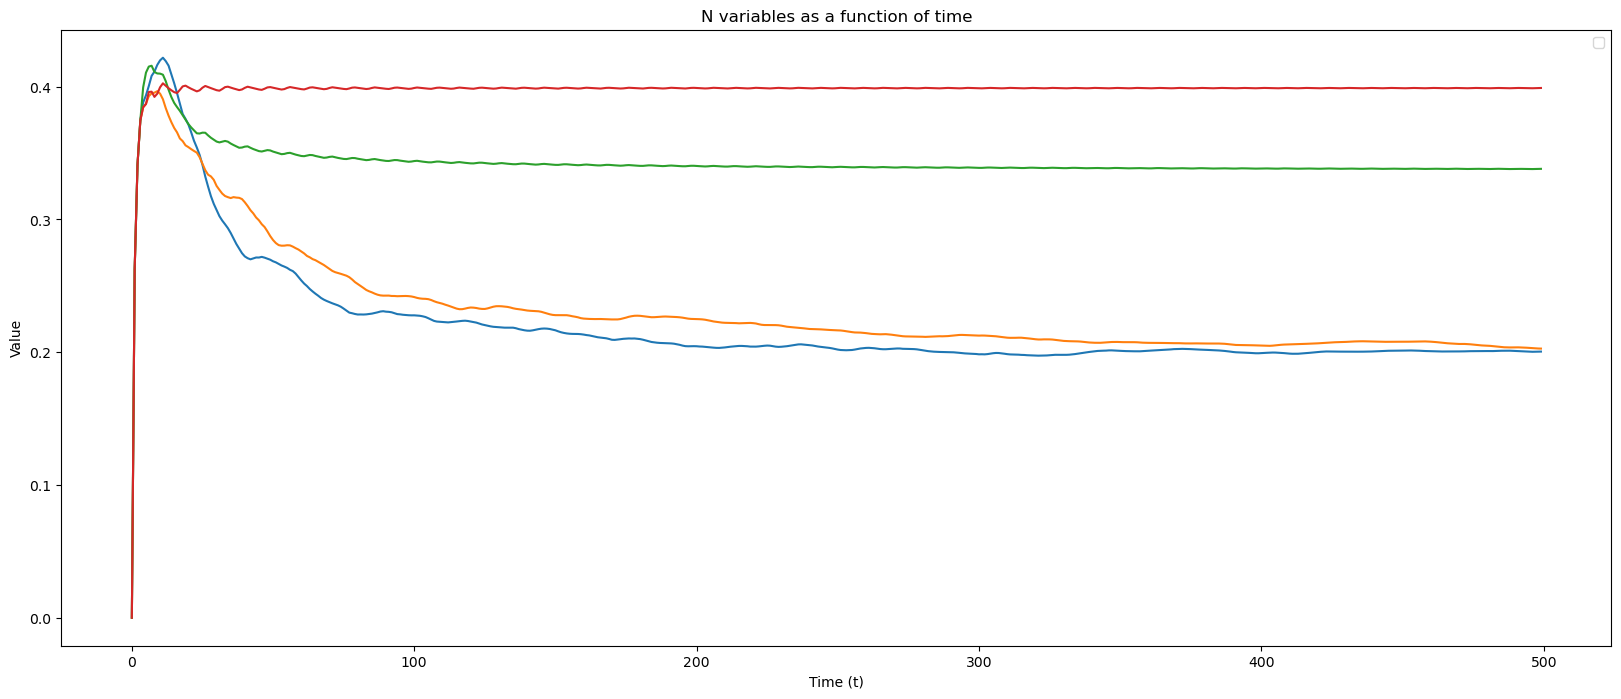

In [267]:
datag=time_averaged_one_point_measures_matrix_full_sim(np.array(tracedistfrom_therm(popsg[12]))[0:500])
datar=time_averaged_one_point_measures_matrix_full_sim(np.array(tracedistfrom_therm(popsr[12]))[0:500])
datam=time_averaged_one_point_measures_matrix_full_sim(np.array(tracedistfrom_therm(popsm[12]))[0:500])
datal=time_averaged_one_point_measures_matrix_full_sim(np.array(tracedistfrom_therm(popsl[12]))[0:500])

#num_time_steps = len(data)  # The number of rows in the data corresponds to the number of time steps
t = np.arange(500)  # Create a list of time steps [0, 1, 2, ..., num_time_steps-1]

data = data.T

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))

plt.plot(t, datar)

plt.plot(t, datag)

plt.plot(t, datam)

plt.plot(t, datal)

# Add labels and legend
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.title('N variables as a function of time')
plt.legend()

# Show the plot
plt.show()